**Made by** - 

Aditya Kothari - I028

**Dataset** - Flickr8k

**Model** - VGG16

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testing-image/812sf.jpeg
/kaggle/input/doggoo/dog.jpg
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/ka

**Importing the required libraries**

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Data Directories**

In [10]:
Data_location = '/kaggle/input/flickr8k'
Data_save = '/kaggle/working'

**Loading the model**

In [6]:
model = VGG16()
#Restructuring the model by removing the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#Summary of the model
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

**Extracting features from the images**

In [7]:
features = {}
directory = os.path.join(Data_location, 'Images')

for img_name in tqdm(os.listdir(directory)):
    #Loading the images
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    #Converting image pixels to numpy array
    image = img_to_array(image)
    #Reshaping data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #Preprocessing the images for vgg
    image = preprocess_input(image)
    #Extracting features of the images
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    
    #Storing the features
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

**Saving the features as a pickle file to load them later without running the function again**

In [11]:
pickle.dump(features, open(os.path.join(Data_save, 'features.pkl'), 'wb'))

In [12]:
#Loading saved features from pickle
with open(os.path.join(Data_save, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [13]:
#Loading the captions
with open(os.path.join(Data_location, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

**Mapping the images to captions**

In [14]:
#Mapping the images to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #Removing extension from image ID
    image_id = image_id.split('.')[0]
    #Converting caption list to string
    caption = " ".join(caption)
    #Create a list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #Storing the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
print("Total no. of maps: ",len(mapping))

Total no. of maps:  8091


**Applying Natural Language Processing techniques to preprocess and clean the captions**

In [18]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            #Converting to lowercase
            caption = caption.lower()
            #Deleting digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            #Deleting additional spaces
            caption = caption.replace('\s+', ' ')
            #Adding start and end tags to the caption
            caption = 'sos ' + " ".join([word for word in caption.split() if len(word)>1]) + ' eos'
            captions[i] = caption

In [19]:
#Before preprocessing of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [20]:
clean(mapping)

**sos** - Start of sentence

**eos** - End of sentence

In [21]:
#After preprocessing of text
mapping['1000268201_693b08cb0e']

['sos child in pink dress is climbing up set of stairs in an entry way eos',
 'sos girl going into wooden building eos',
 'sos little girl climbing into wooden playhouse eos',
 'sos little girl climbing the stairs to her playhouse eos',
 'sos little girl in pink dress going into wooden cabin eos']

In [22]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [23]:
print("Total no. of captions : ",len(all_captions))

Total no. of captions :  40455


In [24]:
all_captions[:10]

['sos child in pink dress is climbing up set of stairs in an entry way eos',
 'sos girl going into wooden building eos',
 'sos little girl climbing into wooden playhouse eos',
 'sos little girl climbing the stairs to her playhouse eos',
 'sos little girl in pink dress going into wooden cabin eos',
 'sos black dog and spotted dog are fighting eos',
 'sos black dog and tri-colored dog playing with each other on the road eos',
 'sos black dog and white dog with brown spots are staring at each other in the street eos',
 'sos two dogs of different breeds looking at each other on the road eos',
 'sos two dogs on pavement moving toward each other eos']

**Tokenization**

In [25]:
#Tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [26]:
print("Size of the vocabulary: ",vocab_size)

Size of the vocabulary:  8485


In [27]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

**Splitting the dataset into train and test sets**

Train - 90%

Test - 10%

In [28]:
#Splitting the images into train and test sets
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Using data generator for Batch processing**

In [29]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            #Processing each caption
            for caption in captions:
                #Encoding
                seq = tokenizer.texts_to_sequences([caption])[0]
                #Splitting into X, y pairs
                for i in range(1, len(seq)):
                    #Splitting into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    #Encoding output sequences
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    #Storing the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

**Creating an Encoder-Decoder model architecture**

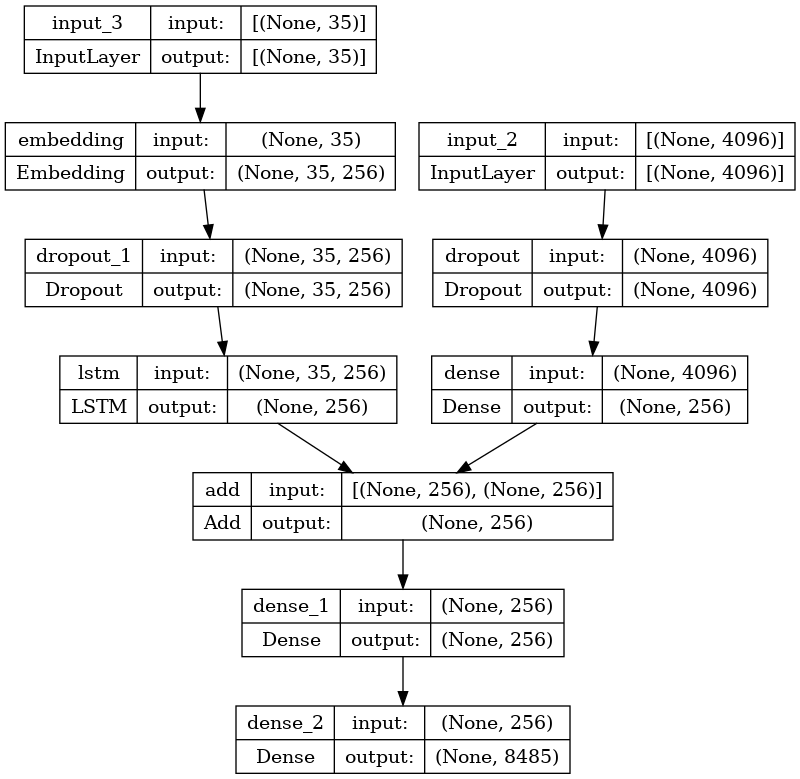

In [30]:
                                                    #Encoder
#Image Feature layers
inputs1 = Input(shape=(4096,))
if1 = Dropout(0.4)(inputs1)
if2 = Dense(256, activation='relu')(if1)

#Sequence feature layers
inputs2 = Input(shape=(max_length,))
sf1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
sf2 = Dropout(0.4)(sf1)
sf3 = LSTM(256)(sf2)

                                                    #Decoder
decoder1 = add([if2, sf3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

**Training the model**

In [32]:
#Training
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)

Epoch 1/5
227/227 [==============================] - 45s 199ms/step - loss: 3.8811
Epoch 2/5
227/227 [==============================] - 47s 206ms/step - loss: 3.5094
Epoch 3/5
227/227 [==============================] - 46s 204ms/step - loss: 3.2585
Epoch 4/5
227/227 [==============================] - 45s 199ms/step - loss: 3.0677
Epoch 5/5
227/227 [==============================] - 45s 196ms/step - loss: 2.9261
Epoch 1/5
227/227 [==============================] - 44s 192ms/step - loss: 2.8154
Epoch 2/5
227/227 [==============================] - 43s 187ms/step - loss: 2.7214
Epoch 3/5
227/227 [==============================] - 43s 187ms/step - loss: 2.6459
Epoch 4/5
227/227 [==============================] - 43s 188ms/step - loss: 2.5804
Epoch 5/5
227/227 [==============================] - 43s 187ms/step - loss: 2.5233
Epoch 1/5
227/227 [==============================] - 43s 190ms/step - loss: 2.4663
Epoch 2/5
227/227 [==============================] - 43s 189ms/step - loss: 2.4151
Epoc

In [34]:
#Saving the model
model.save(Data_save+'/8k_model.h5')

**Converting the indexes back to words**

In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

**Predicting the captions using the trained model**

In [38]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'sos'
    for i in range(max_length):
        #Encoding the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #Padding the sequence
        sequence = pad_sequences([sequence], max_length)
        #Prediction
        ypred = model.predict([image, sequence], verbose=0)
        #Index with high probability
        ypred = np.argmax(ypred)
        word = idx_to_word(ypred, tokenizer)
        
        if word is None:
            break
       #Append the predicted word
        in_text += " " + word
        #Stopping at the end
        if word == 'eos':
            break
      
    return in_text

**Calculating the BLEU score**

In [39]:
from nltk.translate.bleu_score import corpus_bleu
#Checking with the test data
actual, predicted = list(), list()

for key in tqdm(test):
    #Actual Caption
    captions = mapping[key]
    #Predicting the caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
    
#Calculating BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.506760
BLEU-2: 0.284650


**Generating captions for a test image**

In [40]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    #Loading the image
    image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Data_location, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    #Predicting the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
sos black dog and spotted dog are fighting eos
sos black dog and tri-colored dog playing with each other on the road eos
sos black dog and white dog with brown spots are staring at each other in the street eos
sos two dogs of different breeds looking at each other on the road eos
sos two dogs on pavement moving toward each other eos
--------------------Predicted--------------------
sos two dogs play with each other on the grass eos


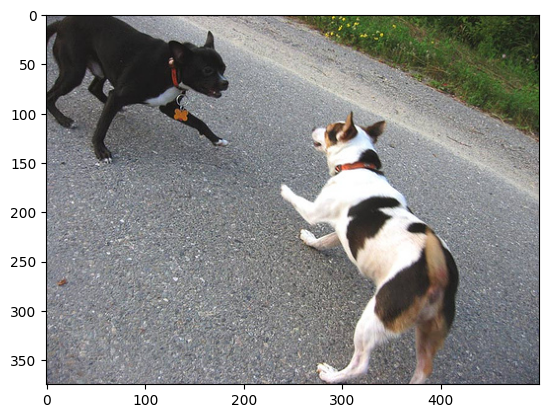

In [41]:
generate_caption("1001773457_577c3a7d70.jpg")

In [42]:
vgg_model = VGG16()
#Restructuring the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

**Generating a caption for a random image taken from the user**

Predicted Caption:  sos two people walking down the street eos


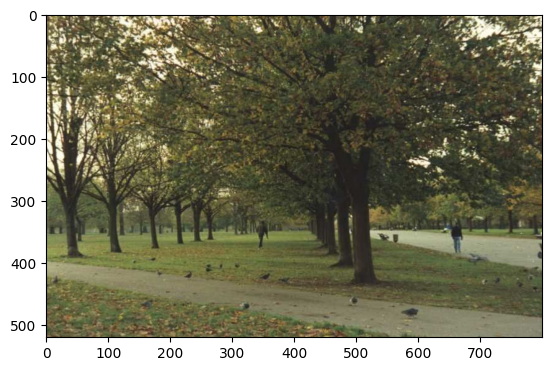

In [60]:
image_path = '/kaggle/input/test-images/1.png'
#Loading the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)
#Predicting the caption
plt.imshow(Image.open(image_path))
print("Predicted Caption: ",predict_caption(model, feature, tokenizer, max_length))